GAN Strcuture (GRU)


In [2]:
import csv
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchtext
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import json
import ast
import glob
import re
import string
import collections

torch.manual_seed(1)

class Discriminator(nn.Module):

    def __init__(self,vocab_size,hidden_size,n_layers=1):
        super(Discriminator, self).__init__()
        self.emb = torch.eye(vocab_size)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(vocab_size,hidden_size,n_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self, x, hidden = None):
        x = self.emb[x]
        hidden = ( torch.zeros(1, x.size(0), self.hidden_size), torch.zeros(1, x.size(0), self.hidden_size) )
        out, hidden = self.rnn(x,hidden)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return torch.sigmoid(out)

class Generator(nn.Module):

    def __init__(self,vocab_size,hidden_size,n_layers=1):
        super(Generator, self).__init__()
        self.emb = torch.eye(vocab_size)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(vocab_size,hidden_size,n_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size,vocab_size)

    def forward(self, x, hidden = None):
        x = self.emb[x]
        if hidden == None:
            hidden = ( torch.zeros(1, x.size(0), self.hidden_size), torch.zeros(1, x.size(0), self.hidden_size) )
        out, hidden = self.rnn(x,hidden)
        out = self.fc1(out)
        return out, hidden



c:\Users\ngche\anaconda3\envs\ailab\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# New Training

Setting HyperParameters

In [3]:
lr = 3e-4
batch_size = 12
num_epochs = 5
max_recipe_len = 100

Formatting Dataset (From Baseline)

In [4]:
patterns = [r'\'', r'\"', r'\.', r'<br \/>', r',', r'\(', r'\)', r'\!', r'\?', r'\:', r'\s+']
replacements = [' \'  ', '', ' . ', ' ', ' , ', ' ( ', ' ) ', ' ! ', ' ? ', ' ', ' ']
patterns_dict = list((re.compile(p), r) for p, r in zip(patterns, replacements))

def basic_english_normalize(line):
    line = line.lower()
    for pattern_re, replaced_str in patterns_dict:
        line = pattern_re.sub(replaced_str, line)
    return line.split()

directions_field = torchtext.data.Field(sequential=True,
                                  tokenize=basic_english_normalize,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True,
                                  init_token="<BOS>",
                                  eos_token="<EOS>")

fields = [('directions', directions_field), ('ingredients', None)]
baseline_data = torchtext.data.TabularDataset("./data/char_nlg_df.csv", "csv", fields)

directions_field.build_vocab(baseline_data)
directions_field.vocab = torchtext.vocab.Vocab(directions_field.vocab.freqs, specials=['<unk>','<pad>', '<BOS>', '<EOS>', ';'])
baseline_vocab_stoi = directions_field.vocab.stoi
baseline_vocab_itos = directions_field.vocab.itos
baseline_vocab_size = len(directions_field.vocab.itos)
print(baseline_vocab_size)
print(directions_field.vocab.itos)

# make data fields for ingredients
ingredients_field = torchtext.data.Field(sequential=True,
                                  tokenize=basic_english_normalize,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True,
                                  init_token="<BOS>",
                                  eos_token="<EOS>")
ing_fields = [('directions', None), ('ingredients', ingredients_field)]
ingredients_data = torchtext.data.TabularDataset("./data/char_nlg_df.csv", "csv", ing_fields)
ingredients_field.build_vocab(baseline_data)
ingredients_field.vocab = torchtext.vocab.Vocab(directions_field.vocab.freqs, specials=['<unk>','<pad>', '<BOS>', '<EOS>', ';'])
ingredients_vocab_stoi = ingredients_field.vocab.stoi
ingredients_vocab_itos = ingredients_field.vocab.itos
ingredients_vocab_size = len(ingredients_field.vocab.itos)
print(ingredients_vocab_size)
print(ingredients_field.vocab.itos)

3502
['<unk>', '<pad>', '<BOS>', '<EOS>', ';', 'and', 'in', 'to', 'add', 'with', 'minutes', 'until', 'a', 'mix', 'for', '1', 'the', 'bake', 'at', 'of', 'into', '2', 'on', 'ingredients', 'sugar', 'over', 'or', 'pour', 'stir', 'pan', 'mixture', '350', 'well', 'cook', 'butter', 'cheese', 'heat', 'water', 'together', 'top', 'inch', 'combine', 'salt', 'flour', 'cream', 'all', 'place', 'oven', 'bowl', 'brown', 'cool', 'milk', 'beat', 'baking', 'x', '4', '3', 'chicken', 'eggs', 'cover', 'put', 'onion', 'about', 'dish', 'sprinkle', 'pepper', 'then', 'cup', 'large', '9', 'serve', '10', 'cut', 'greased', 'drain', '30', 'remaining', 'is', 'remove', 'hours', 'boil', 'from', 'sauce', 'let', 'spread', 'hour', 'egg', 'vanilla', '8', '5', 'cake', 'oil', 'makes', 'set', '6', 'hot', '13', '20', 'nuts', '15', 'meat', 'margarine', 'dry', 'simmer', 'roll', 'stirring', 'casserole', 'medium', 'chill', 'each', 'blend', 'soup', 'juice', 'tender', 'pie', 'melt', 'layer', 'potatoes', 'skillet', 'sheet', 'if', 's

In [41]:
def sample_sequence(model, max_len=1000, temperature=0.8, prior=None):
    generated_sequence = ""
    
    inp = torch.Tensor([baseline_vocab_stoi["<BOS>"]]).long()
    hidden = None
    step = 1

    for c in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        if prior != None:
            output_dist = output_dist * prior
        top = int(torch.multinomial(output_dist, 1)[0])

        predicted_char = baseline_vocab_itos[top]

        if predicted_char == "<pad>":
            continue
        if predicted_char == "<BOS>":
            continue
        if predicted_char == "<unk>":
            continue
        if predicted_char == ";":
            step += 1
            predicted_char = str("\n" + str(step) + ".")
        if predicted_char == "<EOS>":
            break

        generated_sequence += predicted_char + " "
        inp = torch.Tensor([top]).long()

    return generated_sequence

### CURRENT VERSION

In [42]:
def train_GAN(discriminator, generator, data, lr, batch_size, num_epochs, max_recipe_len, temperature, prior=None):
    d_optimizer = optim.Adam(discriminator.parameters(), lr)
    g_optimizer = optim.Adam(generator.parameters(), lr)
    criterion = nn.BCELoss()
    iter = 0
  
    data_iter = torchtext.data.BucketIterator(data, batch_size=batch_size, sort_key=lambda x: len(x.directions), sort_within_batch=True)
    g_losses, d_losses, samples = [],[],[]

    print(len(data_iter))

    for epoch in range(num_epochs):
        avg_loss = 0
        min_loss = float('inf')

        for (directions, lengths), ingredients in data_iter:
            target = directions[:, 1:]
            inp = directions[:, :-1]
            
            # Zero the gradients
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            # -------- Training the Generator ---------#
            
            # Generate a fake recipe
            # The real directions are being used as the input for the generator
            # This will need to be changed to the list of ingredients but for
            # now it acts as "random noise"
            word = torch.Tensor([baseline_vocab_stoi["<BOS>"]]).long()
            hidden = None
            fake_recipe = torch.empty((batch_size, max_recipe_len)).fill_(baseline_vocab_stoi['<pad>'])
            #fake_recipe[0] = baseline_vocab_stoi["<BOS>"] <- forces the first word to be BOS

            for b in range(batch_size):
                for c in range(max_recipe_len - 1):
                    output, hidden = generator(word.unsqueeze(0), hidden)
                    output_dist = output.data.view(-1).div(temperature).exp()
                    if prior != None:
                        output_dist = output_dist * prior
                    top = int(torch.multinomial(output_dist, 1)[0])
                    fake_recipe[b,c] = top
                    word = torch.Tensor([top]).long()
                    # If we reach an 'EOS', stop the tensor here and shorten it.\n",
                    # Might help the GAN identify that it should put EOS at the end\n",
                    if (fake_recipe[b,c] == baseline_vocab_stoi["<EOS>"]):
                        break
                    if (c == max_recipe_len - 2):
                        fake_recipe[b,c+1] = baseline_vocab_stoi["<EOS>"]
                #fake_recipe = fake_recipe.unsqueeze(1)
            fake_recipe = fake_recipe.long()

            # Debugging to see how format of fake_recipe (not accepted by discriminator) differs from inp (accepted by discriminator)
            #print("-------------")
            #print("fake_recipe")
            #print(fake_recipe.type())
            #print(fake_recipe)
            #print("-------------")
            #print("inp")
            #print(inp)

            # Get the discriminator to make a prediction on whether the generated
            # recipe is real or fake
            D_fake = discriminator(fake_recipe, None)

            # Calculate the loss for the generator
            labels = torch.ones_like(D_fake)
            g_loss = criterion(D_fake,labels)
            g_loss.backward()
            g_optimizer.step()

            # -------- Training the Discriminator  ---------#
            # Discriminator losses on real recipes
            D_real = discriminator(inp, None)
            labels = torch.ones_like(D_real)
            d_real_loss = criterion(D_real, labels)

            # Discriminator losses on fake recipes
            #fake_recipe, _ = generator(inp)
            word = torch.Tensor([baseline_vocab_stoi["<BOS>"]]).long()
            hidden = None
            fake_recipe = torch.empty((batch_size, max_recipe_len)).fill_(baseline_vocab_stoi['<pad>'])
            #fake_recipe[0] = baseline_vocab_stoi["<BOS>"] <- forces the first word to be BOS

            for b in range(batch_size):
                for c in range(max_recipe_len - 1):
                    output, hidden = generator(word.unsqueeze(0), hidden)
                    output_dist = output.data.view(-1).div(temperature).exp()
                    top = int(torch.multinomial(output_dist, 1)[0])
                    fake_recipe[b,c] = top
                    word = torch.Tensor([top]).long()
                    # If we reach an 'EOS', stop the tensor here and shorten it.\n",
                    # Might help the GAN identify that it should put EOS at the end\n",
                    if (fake_recipe[b,c] == baseline_vocab_stoi["<EOS>"]):
                        break
                    if (c == max_recipe_len - 2):
                        fake_recipe[b,c+1] = baseline_vocab_stoi["<EOS>"]
                #fake_recipe = fake_recipe.unsqueeze(1)
            fake_recipe = fake_recipe.long()
            
            D_fake = discriminator(fake_recipe, None)
            labels = torch.zeros_like(D_fake)
            d_fake_loss = criterion(D_fake, labels)

            # Add up the losses and update parameters
            # (Some sources say to average the losses but in the tutorial they just add them together)
            d_loss = (d_fake_loss + d_real_loss)
            d_loss.backward()
            d_optimizer.step()

            #loss = criterion(fake_recipes.reshape(-1, baseline_vocab_size), target.reshape(-1))
            
            g_losses.append(float(g_loss))
            d_losses.append(float(d_loss))
            samples.append(iter)

            iter += 1
            if iter % 10 == 0:
                print("----Iteration # %d: g_loss %f, d_loss %f" % (iter+1, g_loss, d_loss))
                print("1. " + sample_sequence(generator, max_recipe_len, temperature, prior))

    plt.title("Generator Loss")
    plt.plot(samples, g_losses, label = "Training")
    plt.xlabel("Iterations")
    plt.ylabel("G Loss")
    plt.show()
    
    plt.title("Discriminator Loss")
    plt.plot(samples, d_losses, label = "Training")
    plt.xlabel("Iterations")
    plt.ylabel("D Loss")
    plt.show()

    return d_losses, g_losses

In [25]:
data_iter = torchtext.data.BucketIterator(baseline_data, batch_size=1, sort_key=lambda x: len(x.directions), sort_within_batch=True)
word_freq = collections.Counter()
    
for (directions, lengths), ingredients in data_iter:
    inp = directions[:, :-1]
    for b in range(1):
        dir_list = inp[b].tolist()
        dir_list.append(baseline_vocab_stoi['<BOS>'])
        dir_list.append(baseline_vocab_stoi['<EOS>'])
        word_freq = word_freq + collections.Counter(dir_list)
            
print(word_freq)

total = 0
for word in word_freq:
    total = total + word_freq[word]
    
print(total)

factor = 1 / total
word_prior = dict(word_freq)
for word in word_prior:
    word_prior[word] = word_prior[word] * factor

temp = {}
for key in sorted(word_prior.keys()):
  temp[key] = word_prior[key]

word_prior = temp

print({key : round(word_prior[key], 4) for key in word_prior})

word_prior_list = [0] * (max(word_prior.keys()) + 1)
for word in word_prior:
    word_prior_list[word] = word_prior[word]
    
print(word_prior_list)

Counter({4: 25142, 5: 11867, 2: 10000, 6: 6870, 3: 5000, 7: 4405, 8: 4153, 9: 3521, 10: 3363, 11: 3356, 12: 3174, 13: 3047, 14: 2942, 15: 2845, 16: 2609, 17: 2430, 18: 2308, 19: 2278, 20: 2105, 21: 2030, 22: 1847, 23: 1759, 24: 1757, 25: 1716, 26: 1711, 27: 1596, 28: 1535, 29: 1526, 30: 1485, 31: 1466, 32: 1396, 33: 1318, 34: 1255, 35: 1238, 36: 1235, 37: 1178, 38: 1175, 39: 1170, 40: 1148, 41: 1143, 42: 1141, 43: 1116, 44: 1110, 45: 990, 46: 948, 47: 915, 48: 902, 49: 884, 50: 881, 51: 879, 52: 864, 53: 853, 54: 819, 55: 810, 56: 804, 57: 774, 58: 773, 59: 759, 60: 741, 61: 730, 64: 725, 62: 725, 63: 725, 65: 723, 66: 712, 67: 707, 68: 706, 69: 701, 70: 681, 71: 680, 72: 670, 73: 651, 74: 634, 75: 630, 76: 619, 77: 617, 78: 575, 79: 572, 80: 568, 82: 568, 81: 568, 83: 565, 84: 560, 85: 559, 86: 558, 87: 555, 88: 553, 89: 549, 90: 500, 91: 494, 92: 488, 93: 470, 95: 454, 94: 454, 97: 453, 96: 453, 98: 443, 99: 442, 100: 442, 101: 438, 102: 437, 103: 428, 104: 424, 105: 423, 106: 422, 1

1000
----Iteration # 11: g_loss 0.618330, d_loss 1.390438
1. boil mix dip 
----Iteration # 21: g_loss 0.591474, d_loss 1.393163
1. pot 3 butter 
2. water cake with line 
3. add minute drop 
4. and a remove melted fold shape 10 and ingredients 15 
----Iteration # 31: g_loss 0.551060, d_loss 1.397701
1. 
2. dish foil beat vegetable feeds 
3. into middle curdle cook and layer small for and seal on spread bake at last and the for of skillet stuffing remaining 
----Iteration # 41: g_loss 0.425930, d_loss 1.389004
1. 5 slice 1 still oil hot at sugar more melt orange raw whip add curry balls pour overnight mixture chops sandwiches other at ready cover nuts with a 
----Iteration # 51: g_loss 0.390448, d_loss 1.475504
1. pecans season crisco stir bake done directions waxed bundt well thoroughly 4 10 shred bake 
2. 
3. 
4. smooth 
5. 1 and water the if all loaf remaining minutes 
----Iteration # 61: g_loss 0.322642, d_loss 1.260427
1. minutes of smooth on may brown liquor bars hour mix at drop s

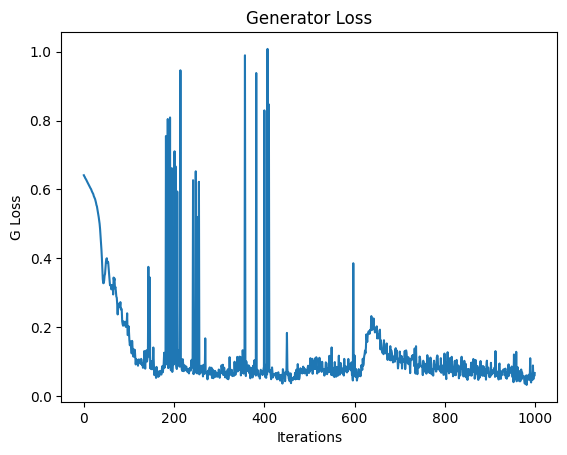

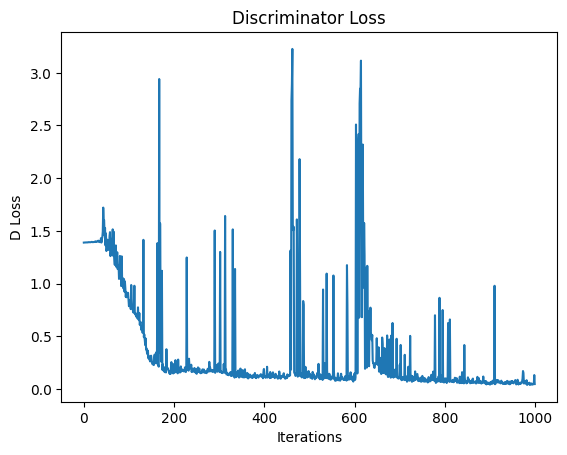

In [44]:
disc = Discriminator(baseline_vocab_size, 128, n_layers=1)
gen = Generator(baseline_vocab_size, 128, n_layers=1)
losses = train_GAN(disc, gen, baseline_data, lr=lr, batch_size=5, num_epochs=1, 
                   max_recipe_len=30, temperature=0.6, prior=torch.FloatTensor(word_prior_list))